# Narrow DNN on CIFAR-10

In [1]:
import sys, os
EXT_DIR = ['..', '../models']
for DIR in EXT_DIR:
    if DIR not in sys.path: sys.path.append(DIR)

import numpy as np
import torch
from torch import nn, tensor
import torch.nn.init as init
from torch.utils.data import Dataset, DataLoader, random_split
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import datasets, transforms
from tqdm import tqdm
import matplotlib.pyplot as plt
import PIL.Image as Image
from sklearn import metrics
import random
import math
import narrow_vgg, narrow_resnet, narrow_mobilenetv2

use_gpu = True # use GPU or CPU
gpu_num = '1' # select GPU if necessary
dataset_path = '../datasets'

if use_gpu:
    os.environ['CUDA_VISIBLE_DEVICES'] = gpu_num # select GPU if necessary
    device = 'cuda'
else:
    device = 'cpu'

batch_size = 128

mean=[0.485, 0.456, 0.406]
std=[0.229, 0.224, 0.225]
cifar10_train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    # transforms.RandomCrop(32, 4),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

cifar10_transform = transforms.Compose([
    
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

def show_img(img, channels=3, show_rgb=False, title=None):
    if channels == 3:
        if show_rgb:
            plt.figure(figsize=(7, 5))
            demo = plt.subplot(231)
            demo.imshow(img.clamp(0., 1.).permute(1, 2, 0))
            demo.axis('off')
            if title is not None: demo.set_title(title)
            demo = plt.subplot(234)
            demo.imshow(img[0].clamp(0., 1.))
            demo.axis('off')
            demo.set_title('[0]')
            demo = plt.subplot(235)
            demo.imshow(img[1].clamp(0., 1.))
            demo.axis('off')
            demo.set_title('[1]')
            demo = plt.subplot(236)
            demo.imshow(img[2].clamp(0., 1.))
            demo.axis('off')
            demo.set_title('[2]')
        else:
            plt.figure(figsize=(2.5, 2.5))
            demo = plt.subplot(111)
            demo.imshow(img.clamp(0., 1.).permute(1, 2, 0))
            demo.axis('off')
            if title is not None: demo.set_title(title)
    elif channels == 1:
        plt.figure(figsize=(2.5, 2.5))
        demo = plt.subplot(111)
        if len(img.shape) == 3: demo.imshow(img[0])
        else: demo.imshow(img)
        demo.axis('off')
        if title is not None: demo.set_title(title)
    plt.show()

In [2]:
dataset_train = datasets.CIFAR10(root=dataset_path, train=True, download=False, transform=cifar10_train_transform)
dataset_val = datasets.CIFAR10(root=dataset_path, train=True, download=False, transform=cifar10_transform)
dataset_test = datasets.CIFAR10(root=dataset_path, train=False, transform=cifar10_transform)

num_train = len(dataset_train)
indices = list(range(num_train))
split = int(np.floor(0.1 * num_train))
# np.random.seed(random_seed)
np.random.shuffle(indices)
train_idx, valid_idx = indices[split:], indices[:split]
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

train_loader = DataLoader(dataset=dataset_train, batch_size=batch_size, sampler=train_sampler, pin_memory=True)
val_loader = DataLoader(dataset=dataset_val, batch_size=batch_size, sampler=valid_sampler)
test_loader = DataLoader(dataset=dataset_test, batch_size=batch_size, shuffle=False)

In [283]:
# Train narrow DNN chain
def eval_chain(
    model,
    target=0,
    eval_loader=None,
    device='cpu'
):
    model.eval()
    target_output = []
    non_target_output = []
    for data, label in eval_loader:
        target_input = data[label == target]
        non_target_input = data[label != target]
        
        if target_input.shape[0] > 0: target_output.extend(model(target_input.to(device=device)).cpu())
        if non_target_input.shape[0] > 0: non_target_output.extend(model(non_target_input.to(device=device)).cpu())
    
    target_output = torch.cat(target_output, dim=0)
    non_target_output = torch.cat(non_target_output, dim=0)
    print("Eval>> avg_target={:.4f}, avg_non_target={:.4f}".format(target_output.mean().item(), non_target_output.mean().item()))
    print("Eval>> target > avg_non_target={:.2f}%".format(torch.sum((target_output > non_target_output.mean()).int()) / target_output.shape[0] * 100))
    print("Eval>> non_target < avg_non_target={:.2f}%".format(torch.sum((non_target_output < non_target_output.mean()).int()) / non_target_output.shape[0] * 100))

    plt.hist(non_target_output.cpu().detach().numpy(), bins=30, alpha=.8, label='Non-target Inputs')
    plt.hist(target_output.cpu().detach().numpy(), bins=30, alpha=.8, label='Target Inputs')
    plt.title("[Eval] Chain Activation Histogram")
    plt.xlabel("Chain Activation Value")
    plt.ylabel("Number of Inputs")
    plt.legend()
    plt.show()

def train_chain(
    model,
    target=0,
    # target_data=None,
    # non_target_data=None,
    eval_loader=None,
    num_epoch=5,
    opt='sgd',
    lr=1e-3,
    batch_size=64,
    device='cpu'
):

    assert opt == 'sgd' or 'adam'
    if opt == 'sgd': optimizer = torch.optim.SGD(model.parameters(), lr=lr)#, momentum = 0.9, weight_decay=0.01)
    elif opt == 'adam': optimizer = torch.optim.Adam(model.parameters(), lr=lr)#, weight_decay=10)
    # lr_scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[5], gamma=0.5)
    for epoch in range(num_epoch):
        model.train()
        n_iter = 0
        loss_t = 0
        loss_n = 0
        
        # if len(target_data) == len(non_target_data):
        #     target_data_lader = DataLoader(dataset=target_data, batch_size=batch_size, shuffle=True)
        #     non_target_data_lader = DataLoader(dataset=non_target_data, batch_size=batch_size, shuffle=True)
        #     tq = tqdm(zip(target_data_lader, non_target_data_lader), desc='{} E{:03d}'.format('Train>>', epoch), ncols=0)
        # else:
        #     raise NotImplementedError()
        
        tq = tqdm(train_loader, desc='{} E{:03d}'.format('Train>>', epoch), ncols=0)
        # for target_input, non_target_input in tq:
        for inputs, label in tq:
            target_input = inputs[label == target]
            non_target_input = inputs[label != target]

            model.train()
            n_iter += 1

            # Clear grad
            optimizer.zero_grad()

            # Prediction
            if target_input.shape[0] == 0: continue
            target_output = model(target_input.to(device=device))
            non_target_output = model(non_target_input.to(device=device))

            # Non-target inputs should have 0 activation, target inputs should have a large activation, e.g. 20 
            loss_n = non_target_output.mean()
            loss_t = target_output.mean()
            
            # Strategy 1 (old)
            # loss = loss_n * 10 + 2 * (loss_t - 20) ** 2

            # Strategy 2 (lr: 1e-2 or 1e-3 or 1e-4)
            # loss_n = non_target_output.mean()
            loss_n = ((non_target_output + 5) ** 2).sum() / non_target_output.shape[0]
            loss_t = ((target_output - 30) ** 2).sum() / target_output.shape[0]
            loss = 4 * loss_n + 1 * loss_t
            loss_n = non_target_output.mean()
            loss_t = target_output.mean()
            ## L2 Regularization (optional)
            # lambda2 = 1e-2
            # all_params = torch.cat([x.view(-1) for x in model.parameters()])
            # l2_regularization = lambda2 * torch.norm(all_params, 2)
            # loss += l2_regularization
            
            # Backprop & Optimize
            loss.backward()
            optimizer.step()

            tq.set_postfix(
                lr='{}'.format(optimizer.param_groups[0]['lr']),
                loss='{}'.format(loss.item()),
                avg_target='{:.4f}'.format(target_output.mean().item()),
                avg_non_target='{:.4f}'.format(non_target_output.mean().item()),
                diff='{:.4f}'.format(target_output.mean().item() - non_target_output.mean().item())
            )
        
        # lr_scheduler.step()
        eval_chain(model=model, target=target, eval_loader=eval_loader, device=device)
    plt.hist(non_target_output.cpu().detach().numpy(), bins=20, alpha=.8, label='Non-target Inputs')
    plt.hist(target_output.cpu().detach().numpy(), bins=10, alpha=.8, label='Target Inputs')
    plt.title("[Train] Chain Activation Histogram")
    plt.xlabel("Chain Activation Value")
    plt.ylabel("Number of Inputs")
    plt.legend()
    plt.show()
    return model

In [246]:
from importlib import reload
narrow_vgg = reload(narrow_vgg)

Train>> E000: 100% 352/352 [00:19<00:00, 18.44it/s, avg_non_target=2.2795, avg_target=4.8088, diff=2.5292, loss=890.078857421875, lr=0.001]  


Eval>> avg_target=4.5161, avg_non_target=2.2413
Eval>> target > avg_non_target=62.98%
Eval>> non_target < avg_non_target=66.73%


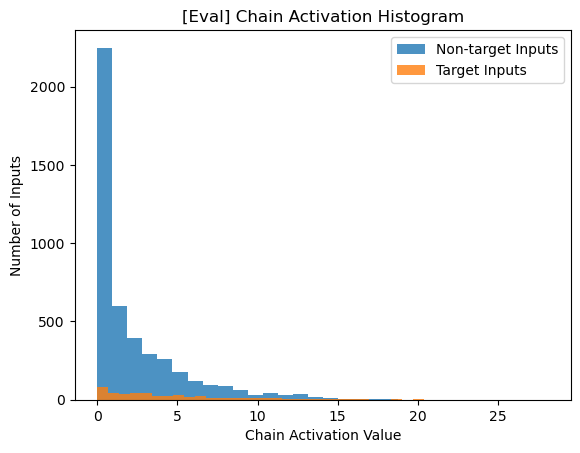

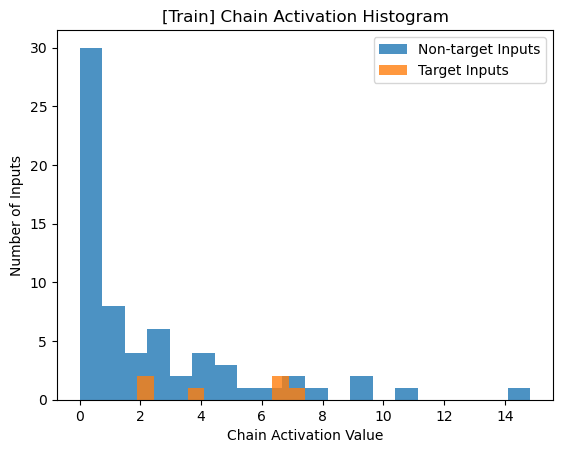

narrow_VGG(
  (features): Sequential(
    (0): Conv2d(3, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=Fal

In [284]:
target = 3

# Initialize the narrow model
# narrow_model = narrow_vgg.narrow_cifar10_vgg().to(device=device)
# narrow_model = narrow_resnet.narrow_resnet110().to(device=device)
# narrow_model = narrow_mobilenetv2.narrow_mobilenetv2().to(device=device)
# for m in narrow_model.modules():
#     if isinstance(m, nn.Linear) or isinstance(m, nn.Conv2d) or isinstance(m, nn.BatchNorm2d):
#         init.normal_(m.weight)
#         if m.bias is not None:
#             m.bias.data.zero_()

train_chain(
    model=narrow_model,
    target=target,
    # target_data=train_target_samples,
    # non_target_data=train_non_target_samples,
    eval_loader=val_loader,
    num_epoch=1,
    opt='adam',
    lr=1e-3,
    # batch_size=128,
    device=device
)

In [126]:
print(len(list(narrow_model.parameters())))

28


In [ ]:
eval_chain(
    model=narrow_model,
    target=target,
    eval_loader=val_loader,
    device=device
)

### Save

In [240]:
path = '../checkpoints/CIFAR10/narrow_target%d_nobm.ckpt' % target
torch.save(narrow_model.state_dict(), path)
print('Saved at {}'.format(path))

Saved at ../checkpoints/CIFAR10/narrow_target1_nobm.ckpt


### Load

Eval>> avg_target=7.5584, avg_non_target=3.4729
Eval>> target > avg_non_target=71.70%
Eval>> non_target < avg_non_target=62.08%


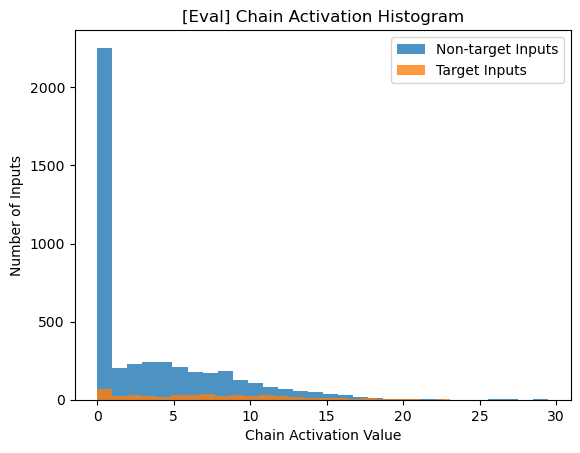

In [285]:
target = 3
path = '../checkpoints/CIFAR10/narrow_target%d_nobm_old.ckpt' % target

narrow_model = narrow_vgg.narrow_cifar10_vgg()
narrow_model.load_state_dict(torch.load(path))
narrow_model = narrow_model.to(device=device)

eval_chain(
    model=narrow_model,
    target=target,
    eval_loader=val_loader,
    device=device
)

## Aggregate

In [307]:
class agg_chains():
    def __init__(self, class_num, chains, device='cpu'):
        assert len(chains) == class_num
        self.class_num = class_num
        self.chains = chains
        self.device = device
    def forward(self, x):
        outputs = []
        for i in range(self.class_num):
            outputs.append(self.chains[i](x))
        outputs = torch.cat(outputs, dim=1)
        return outputs

def eval_agg_chains(agg_model, eval_loader, device='cpu'):
    per_class_cnt = [0 for i in range(10)]
    per_class_correct_cnt = [0 for i in range(10)]
    correct_cnt = 0
    all_cnt = 0
    overall_acc = 0
    per_class_acc = [0 for i in range(10)]
    for data, label in eval_loader:
        outputs = agg_model.forward(data.to(device)).cpu()
        pred = torch.argmax(outputs, dim=1)
        
        correct_cnt += torch.sum((pred == label).int())
        all_cnt += pred.shape[0]
        
        for i in range(10):
            per_class_correct_cnt[i] += torch.sum(torch.logical_and(pred == i, label == i).int())
            per_class_cnt[i] += torch.sum((label == i).int())
    overall_acc = (correct_cnt / all_cnt) * 100
    print("Acc: {:.2f}%".format(overall_acc))
    
    for i in range(10):
        per_class_acc[i] = (per_class_correct_cnt[i] / per_class_cnt[i]) * 100
        print("Class {} Acc: {:.2f}%".format(i, per_class_acc[i]))

    return overall_acc, per_class_acc

In [292]:
narrow_models = []

for i in range(10):
    path = '../checkpoints/CIFAR10/narrow_target%d_nobm.ckpt' % i
    narrow_models.append(narrow_vgg.narrow_cifar10_vgg())
    narrow_models[i].load_state_dict(torch.load(path))
    narrow_models[i] = narrow_models[i].to(device=device)

In [293]:
agg_model = agg_chains(10, narrow_models, device=device)

In [308]:
overall_acc, per_class_acc = eval_agg_chains(agg_model=agg_model, eval_loader=test_loader, device=device)

Acc: 47.72%
Class 0 Acc: 48.90%
Class 1 Acc: 55.70%
Class 2 Acc: 43.50%
Class 3 Acc: 31.80%
Class 4 Acc: 41.00%
Class 5 Acc: 45.40%
Class 6 Acc: 61.90%
Class 7 Acc: 42.00%
Class 8 Acc: 49.90%
Class 9 Acc: 57.10%


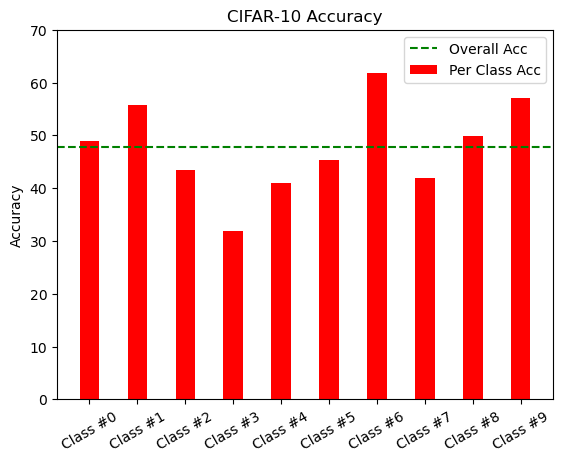

In [319]:
x = [0 + 2 * i for i in range(10)]
labels = ['Class #{}'.format(i) for i in range(10)]

plt.axhline(overall_acc, linestyle="--", color="g", label='Overall Acc')
plt.bar(x, per_class_acc, color='r', label='Per Class Acc')
plt.xticks(x, labels=labels, rotation=30)
plt.ylim(0, 70)

ax=plt.gca()
ax.yaxis.set_major_locator(plt.MultipleLocator(10))
plt.ylabel("Accuracy")

plt.title('CIFAR-10 Accuracy')

plt.legend()

plt.show()

# plt.savefig('../assets/per-class-acc-cifar10.png')

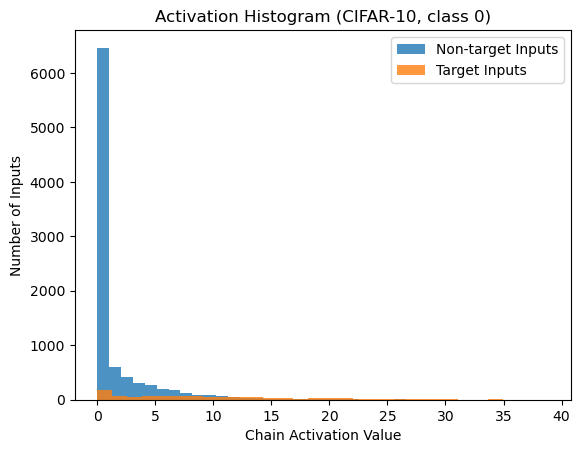

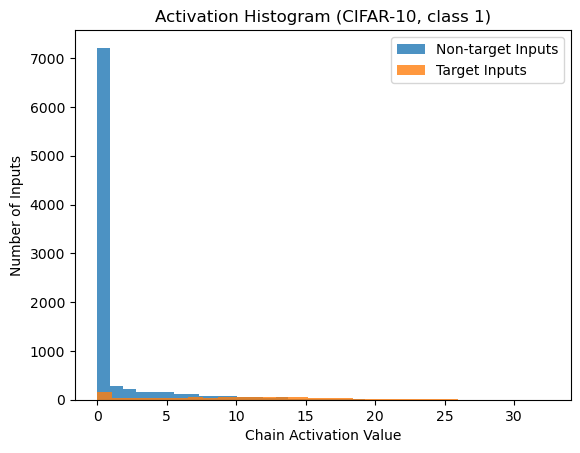

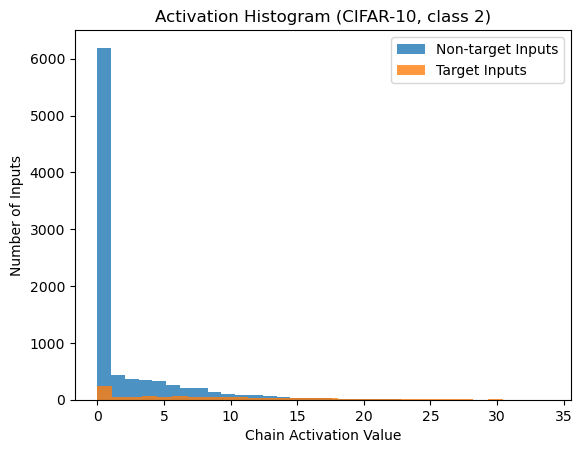

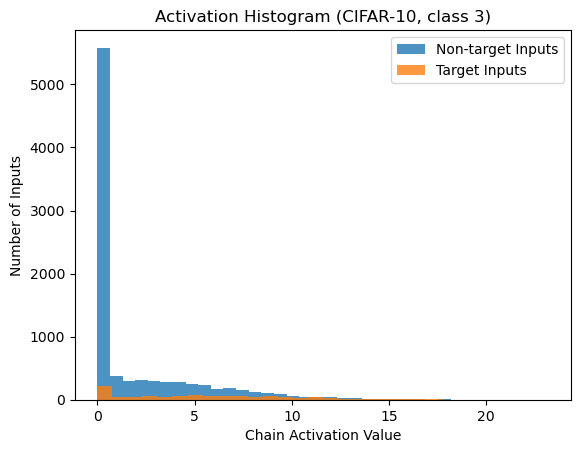

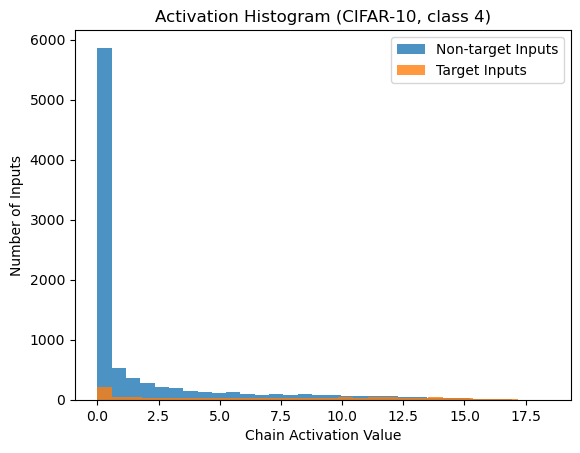

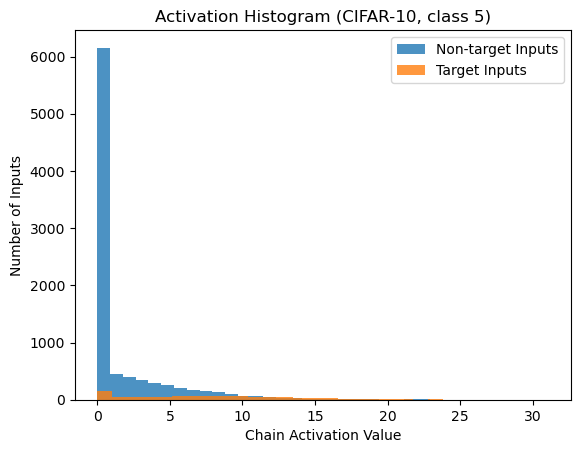

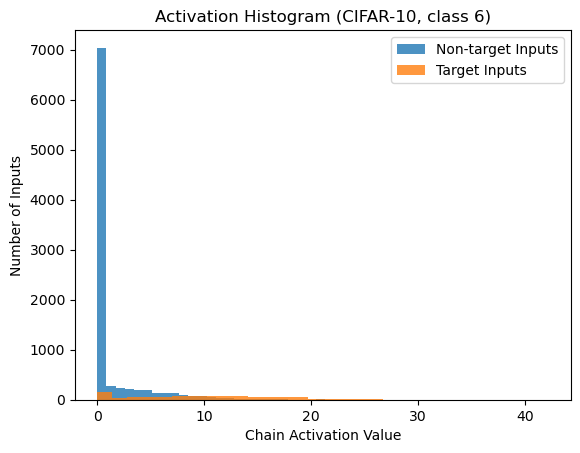

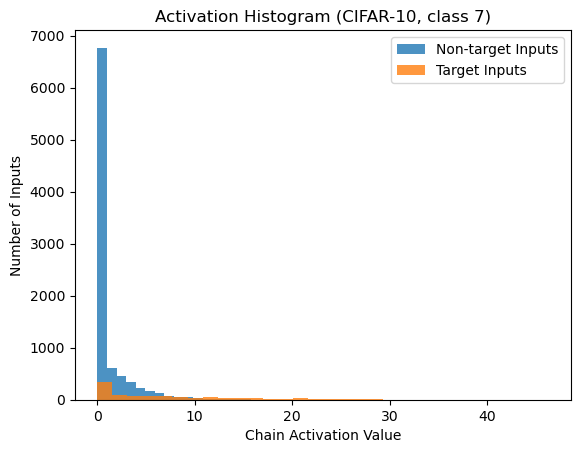

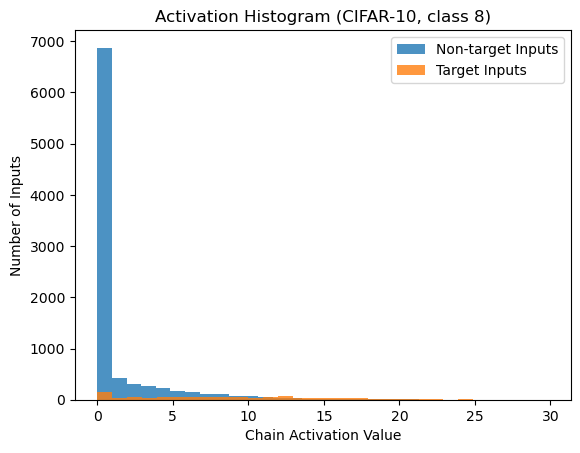

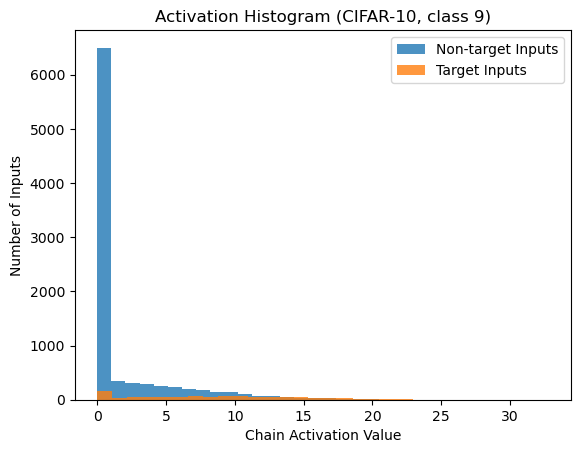

In [8]:
task = 'CIFAR-10'

if task == 'MNIST':
    narrow_arch = narrow_vgg.narrow_mnist_vgg
    ckpt_path = '../checkpoints/MNIST/'
elif task == 'Fashion-MNIST':
    narrow_arch = narrow_vgg.narrow_fashionmnist_vgg
    ckpt_path = '../checkpoints/FashionMNIST/'
elif task == 'CIFAR-10':
    narrow_arch = narrow_vgg.narrow_cifar10_vgg
    ckpt_path = '../checkpoints/CIFAR10/'
else: raise NotImplementedError("`task` must be MNIST, Fashion-MNIST, or CIFAR-10")

def plot_chain_activation_distribution(
    model,
    target=0,
    eval_loader=None,
    device='cpu'
):
    model.eval()
    target_output = []
    non_target_output = []
    for data, label in eval_loader:
        target_input = data[label == target]
        non_target_input = data[label != target]
        
        if target_input.shape[0] > 0: target_output.extend(model(target_input.to(device=device)).cpu())
        if non_target_input.shape[0] > 0: non_target_output.extend(model(non_target_input.to(device=device)).cpu())
    
    target_output = torch.cat(target_output)
    non_target_output = torch.cat(non_target_output)
    # print("Eval>> avg_target={:.4f}, avg_non_target={:.4f}".format(target_output.mean().item(), non_target_output.mean().item()))

    plt.hist(non_target_output.cpu().detach().numpy(), bins=30, alpha=.8, label='Non-target Inputs')
    plt.hist(target_output.cpu().detach().numpy(), bins=30, alpha=.8, label='Target Inputs')
    plt.title("Activation Histogram ({}, class {})".format(task, target))
    plt.xlabel("Chain Activation Value")
    plt.ylabel("Number of Inputs")
    plt.legend()
    plt.savefig('../assets/histogram_{}_{}.png'.format(task, i))
    plt.show()

for i in range(10):
    path = ckpt_path + 'narrow_target%d_nobm.ckpt' % i
    narrow_model = narrow_arch()
    narrow_model.load_state_dict(torch.load(path))
    narrow_model = narrow_model.to(device=device)
    plot_chain_activation_distribution(narrow_model, i, test_loader, device=device)

ROC AUC: 0.8518216666666667


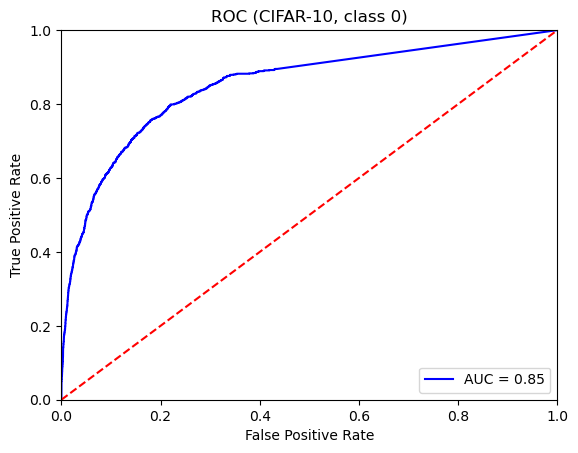

ROC AUC: 0.8708802222222223


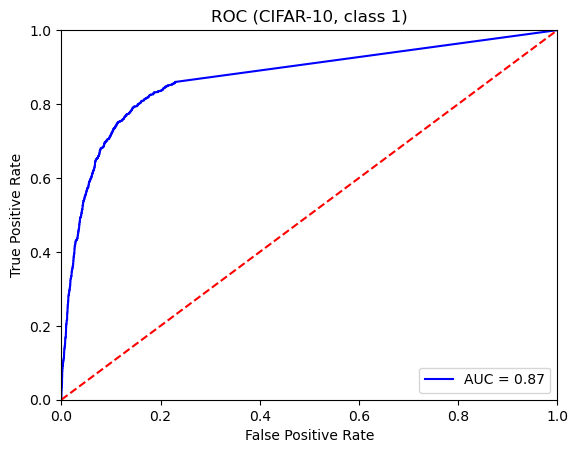

ROC AUC: 0.7803879999999999


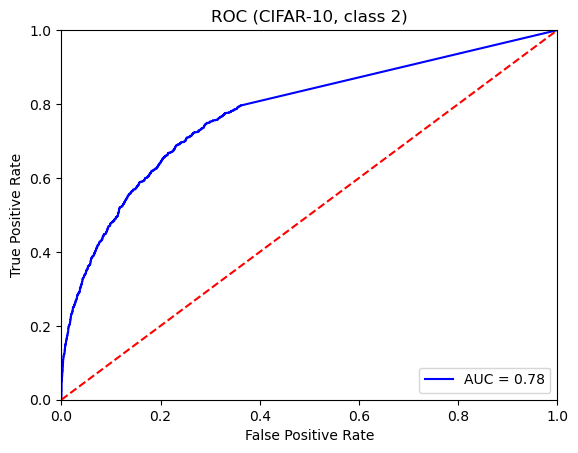

ROC AUC: 0.7623206666666666


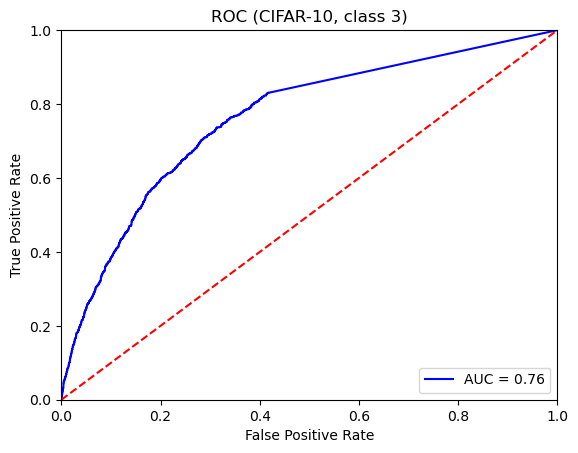

ROC AUC: 0.7865282222222221


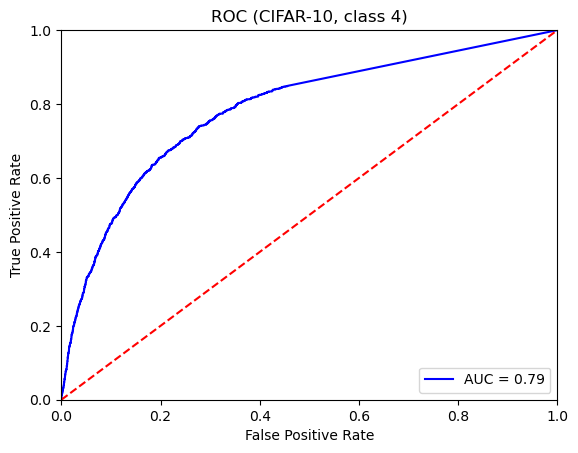

ROC AUC: 0.8378074444444444


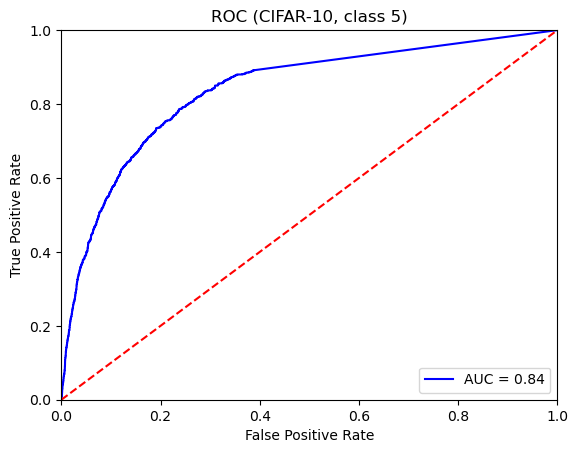

ROC AUC: 0.8904828333333333


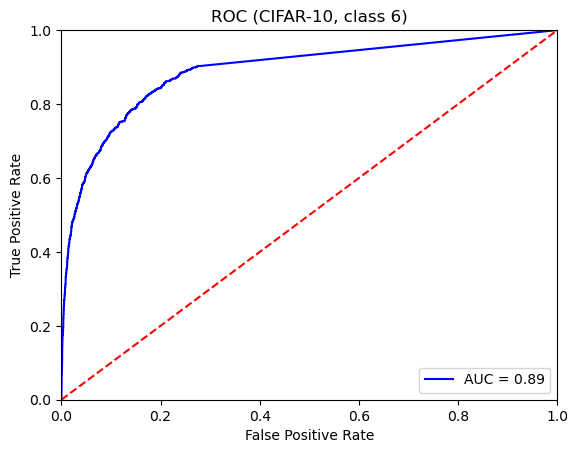

ROC AUC: 0.791632611111111


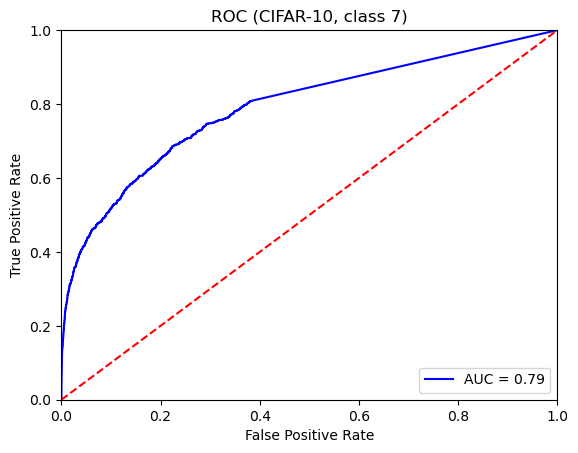

ROC AUC: 0.8705948888888889


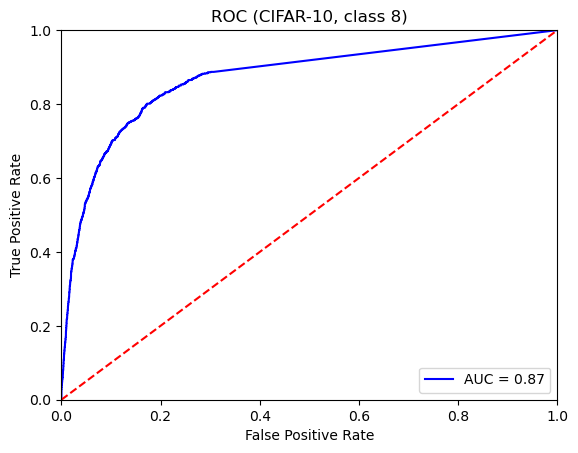

ROC AUC: 0.8476408888888889


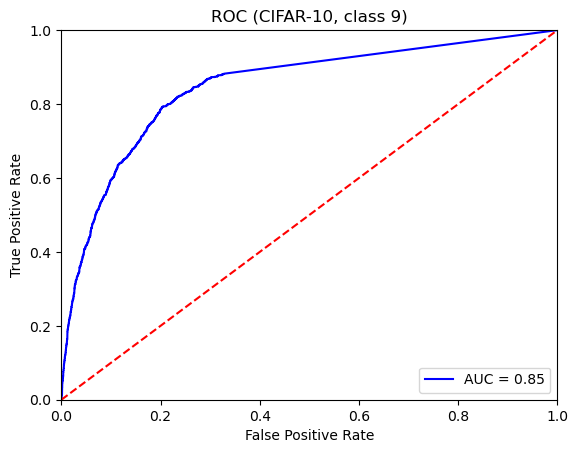

[0.8518216666666667, 0.8708802222222223, 0.7803879999999999, 0.7623206666666666, 0.7865282222222221, 0.8378074444444444, 0.8904828333333333, 0.791632611111111, 0.8705948888888889, 0.8476408888888889]


In [4]:
task = 'CIFAR-10'

if task == 'MNIST':
    narrow_arch = narrow_vgg.narrow_mnist_vgg
    ckpt_path = '../checkpoints/MNIST/'
elif task == 'Fashion-MNIST':
    narrow_arch = narrow_vgg.narrow_fashionmnist_vgg
    ckpt_path = '../checkpoints/FashionMNIST/'
elif task == 'CIFAR-10':
    narrow_arch = narrow_vgg.narrow_cifar10_vgg
    ckpt_path = '../checkpoints/CIFAR10/'
else: raise NotImplementedError("`task` must be MNIST, Fashion-MNIST, or CIFAR-10")

def calc_auc(
    model,
    target=0,
    eval_loader=None,
    device='cpu'
):
    model.eval()
    target_output = []
    non_target_output = []
    for data, label in eval_loader:
        target_input = data[label == target]
        non_target_input = data[label != target]
        
        if target_input.shape[0] > 0: target_output.extend(model(target_input.to(device=device)).cpu())
        if non_target_input.shape[0] > 0: non_target_output.extend(model(non_target_input.to(device=device)).cpu())
    
    target_output = torch.cat(target_output)
    non_target_output = torch.cat(non_target_output)
    # print("Eval>> avg_target={:.4f}, avg_non_target={:.4f}".format(target_output.mean().item(), non_target_output.mean().item()))

    outputs = torch.cat((target_output, non_target_output), dim=0)
    labels = torch.zeros_like(outputs)
    labels[:target_output.shape[0]] = 1
    fpr, tpr, threshold = metrics.roc_curve(labels.cpu().detach(), outputs.cpu().detach())
    roc_auc = metrics.auc(fpr, tpr)
    print("ROC AUC:", roc_auc)
    plt.title("ROC ({}, class {})".format(task, target))
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.savefig('../assets/roc_{}_{}.png'.format(task, i))
    plt.show()

    return roc_auc

roc_aucs = []
for i in range(10):
    path = ckpt_path + 'narrow_target%d_nobm.ckpt' % i
    narrow_model = narrow_arch()
    narrow_model.load_state_dict(torch.load(path))
    narrow_model = narrow_model.to(device=device)
    roc_auc = calc_auc(narrow_model, i, test_loader, device=device)
    roc_aucs.append(roc_auc)

print(roc_aucs)